In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from bs4 import BeautifulSoup
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
import re
import spacy
import unicodedata

# Part 1 EDA

In [382]:
df_train = pd.read_csv('HD/train.csv')
df_test = pd.read_csv('HD/test.csv')
df_pro_desc = pd.read_csv('HD/product_descriptions.csv')
df_attr = pd.read_csv('HD/attributes.csv', error_bad_lines=False)

In [383]:
df_train.shape

(74067, 5)

In [384]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [385]:
df_test.shape

(166693, 4)

In [386]:
df_test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [387]:
df_pro_desc.shape

(124428, 2)

In [388]:
df_pro_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [389]:
df_attr.shape

(2044803, 3)

In [390]:
df_attr.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [391]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


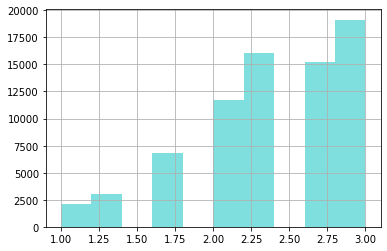

In [392]:
df_train.relevance.hist(color='c', alpha=0.5)
plt.show()

In [393]:
df_train.product_uid.nunique()

54667

In [394]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
id               166693 non-null int64
product_uid      166693 non-null int64
product_title    166693 non-null object
search_term      166693 non-null object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB


In [395]:
df_test.product_uid.nunique()

97460

In [396]:
df_pro_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
product_uid            124428 non-null int64
product_description    124428 non-null object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [397]:
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044803 entries, 0 to 2044802
Data columns (total 3 columns):
product_uid    float64
name           object
value          object
dtypes: float64(1), object(2)
memory usage: 46.8+ MB


In [398]:
df_attr.name.value_counts().head(10)

MFG Brand Name          86250
Bullet02                86248
Bullet03                86226
Bullet04                86174
Bullet01                85940
Product Width (in.)     61137
Bullet05                60529
Product Height (in.)    54698
Product Depth (in.)     53652
Product Weight (lb.)    45175
Name: name, dtype: int64

In [399]:
df_attr.isnull().sum(axis = 0)

product_uid     155
name            155
value          2284
dtype: int64

# Part 2 Text Preprocessing

In [400]:
df_brand = df_attr[df_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})

In [401]:
df_brand['product_uid'] = df_brand.product_uid.astype('int')
df_brand['brand'] = df_brand.brand.astype(str)

In [402]:
df_brand.shape

(86250, 2)

In [403]:
df_brand.head(10)

,product_uid,brand
9,100001,Simpson Strong-Tie
37,100002,BEHR Premium Textured DeckOver
69,100003,STERLING
93,100004,Grape Solar
122,100005,Delta
163,100006,Whirlpool
204,100007,Lithonia Lighting
236,100008,Teks
256,100009,House of Fara
283,100010,Valley View Industries


In [404]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
df_all = pd.merge(df_all, df_brand, how = 'left', on = 'product_uid')

df_all.head()

C:\Users\17520-1906\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,id,product_title,product_uid,relevance,search_term,product_description,brand
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta


In [405]:
def str_pro(text):
    text = re.sub(r"(\w)\.([A-Z])", r"\1 \2", text)
    text = text.lower()
    text = re.sub('[^a-zA-z0-9\s]', ' ', text)
    text = text.replace("  "," ")
    return text

In [406]:
def str_html(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [407]:
def str_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [408]:
stemmer = SnowballStemmer('english')
def str_stemmer(text):
    text =  " ".join([stemmer.stem(word) for word in text.lower().split()])
    return text

In [409]:
wordnet_lemmatizer = WordNetLemmatizer()
def str_lemmanize(text):
    text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text.lower().split()])
    return text

In [410]:
def str_rm_stopwords(text):
    text = " ".join([word for word in text.lower().split()if word not in stopwords.words('english')])
    return text

In [411]:
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [412]:
df_attr_stripped = df_attr
df_attr_stripped['name'] = df_attr_stripped.name.astype(str)
df_attr_stripped['name'] = df_attr_stripped['name'].apply(lambda s: re.sub(r"Bullet([0-9]+)", "", s))

In [413]:
df_attr_stripped.head(10)

,product_uid,name,value
0,100001.0,,Versatile connector for various 90° connection...
1,100001.0,,Stronger than angled nailing or screw fastenin...
2,100001.0,,Help ensure joints are consistently straight a...
3,100001.0,,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,,Made from 12-Gauge steel
5,100001.0,,Galvanized for extra corrosion resistance
6,100001.0,,Install with 10d common nails or #9 x 1-1/2 in...
7,100001.0,Gauge,12
8,100001.0,Material,Galvanized Steel
9,100001.0,MFG Brand Name,Simpson Strong-Tie


In [414]:
df_attr_stripped['attribute'] = df_attr_stripped['name'] + " " + df_attr_stripped['value']

df_attr_stripped.head(10)

,product_uid,name,value,attribute
0,100001.0,,Versatile connector for various 90° connection...,Versatile connector for various 90° connectio...
1,100001.0,,Stronger than angled nailing or screw fastenin...,Stronger than angled nailing or screw fasteni...
2,100001.0,,Help ensure joints are consistently straight a...,Help ensure joints are consistently straight ...
3,100001.0,,Dimensions: 3 in. x 3 in. x 1-1/2 in.,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,,Made from 12-Gauge steel,Made from 12-Gauge steel
5,100001.0,,Galvanized for extra corrosion resistance,Galvanized for extra corrosion resistance
6,100001.0,,Install with 10d common nails or #9 x 1-1/2 in...,Install with 10d common nails or #9 x 1-1/2 i...
7,100001.0,Gauge,12,Gauge 12
8,100001.0,Material,Galvanized Steel,Material Galvanized Steel
9,100001.0,MFG Brand Name,Simpson Strong-Tie,MFG Brand Name Simpson Strong-Tie


In [415]:
df_attr_test = df_attr_stripped.groupby('product_uid').agg({'attribute': lambda s : ' '.join(s.astype(str))}).reset_index()

df_attr_test.head()

,product_uid,attribute
0,100001.0,Versatile connector for various 90° connectio...
1,100002.0,"Application Method Brush,Roller,Spray Assemble..."
2,100003.0,Built-in flange Yes Slightly narrower for tig...
3,100004.0,Amperage (amps) 8.56 Positive power tolerance...
4,100005.0,Bath Faucet Type Combo Tub and Shower Built-in...


In [416]:
df_all = pd.merge(df_all, df_attr_test, how = 'left', on = 'product_uid')

df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description,brand,attribute
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90° connectio...
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90° connectio...
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,"Application Method Brush,Roller,Spray Assemble..."
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...


In [417]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_pro(str(x)))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_pro(str(x)))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_pro(str(x)))
df_all['attribute'] = df_all['attribute'].map(lambda x:str_pro(str(x)))

In [418]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_html(str(x)))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_html(str(x)))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_html(str(x)))
df_all['attribute'] = df_all['attribute'].map(lambda x:str_html(str(x)))

In [419]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_accented_chars(str(x)))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_accented_chars(str(x)))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_accented_chars(str(x)))
df_all['attribute'] = df_all['attribute'].map(lambda x:str_accented_chars(str(x)))

In [420]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_lemmanize(str(x)))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_lemmanize(str(x)))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_lemmanize(str(x)))
df_all['attribute'] = df_all['attribute'].map(lambda x:str_lemmanize(str(x)))

In [421]:
df_all['search_term'] = pd.Series(df_all['search_term'].map(lambda x:str_stemmer(str(x))))
df_all['product_title'] = pd.Series(df_all['product_title'].map(lambda x:str_stemmer(str(x))))
df_all['product_description'] = pd.Series(df_all['product_description'].map(lambda x:str_stemmer(str(x))))
df_all['attribute'] = pd.Series(df_all['attribute'].map(lambda x:str_stemmer(str(x))))

In [422]:
df_all.head(10)

,id,product_title,product_uid,relevance,search_term,product_description,brand,attribute
0,2,simpson strong tie 12 gaug angl,100001,3.00,angl bracket,not onli do angl make joint stronger they also...,Simpson Strong-Tie,versatil connector for various 90 connect and ...
1,3,simpson strong tie 12 gaug angl,100001,2.50,l bracket,not onli do angl make joint stronger they also...,Simpson Strong-Tie,versatil connector for various 90 connect and ...
2,9,behr premium textur deckov 1 gal sc 141 tugboa...,100002,3.00,deck over,behr premium textur deckov is an innov solid c...,BEHR Premium Textured DeckOver,applic method brush roller spray assembl depth...
3,16,delta vero 1 handl shower onli faucet trim kit...,100005,2.33,rain shower head,updat your bathroom with the delta vero singl ...,Delta,bath faucet type combo tub and shower built in...
4,17,delta vero 1 handl shower onli faucet trim kit...,100005,2.67,shower onli faucet,updat your bathroom with the delta vero singl ...,Delta,bath faucet type combo tub and shower built in...
5,18,whirlpool 1 9 cu ft over the rang convect micr...,100006,3.00,convect otr,achiev delici result is almost effortless with...,Whirlpool,applianc type over the rang microwav assembl d...
6,20,whirlpool 1 9 cu ft over the rang convect micr...,100006,2.67,microwav over stove,achiev delici result is almost effortless with...,Whirlpool,applianc type over the rang microwav assembl d...
7,21,whirlpool 1 9 cu ft over the rang convect micr...,100006,3.00,microwav,achiev delici result is almost effortless with...,Whirlpool,applianc type over the rang microwav assembl d...
8,23,lithonia light quantum 2 light black led emerg...,100007,2.67,emerg light,the quantum adjust 2 light led black emerg lig...,Lithonia Lighting,batteri power type ni cad batteri size built i...
9,27,hous of fara 3 4 in x 3 in x 8 ft mdf flute case,100009,3.00,mdf 3 4,get the hous of fara 3 4 in x 3 in x 8 ft mdf ...,House of Fara,applic door window made of prime mdf can be pa...
